## Import Modules


In [1]:
import os
import re
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
base_directory = 'D:\Cs_Internship\CS\step12\image_captioning'
working_dir = 'D:\Cs_Internship\CS\step12\image_captioning'

## Extract Image Features

In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
features = {}
image_directory= os.path.join(base_directory, 'Images')

for img_name in tqdm(os.listdir(image_directory)):
    img_path = os.path.join(image_directory, img_name)
    
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    
    feature = model.predict(image)
    
    image_id = img_name.split('.')[0]
    features[image_id] = feature

### save image features 

In [5]:
pickle.dump(features, open(os.path.join(working_dir, 'features.pkl'), 'wb'))

In [5]:
with open(os.path.join(working_dir, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Read Captions

In [7]:
with open(os.path.join(base_directory, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

### create a list of all captions for each image

In [8]:
mapping = {}

lines = captions_doc.strip().split('\n')
mapping = {}

for line in lines:
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, caption = tokens[0].split('.')[0], " ".join(tokens[1:]).strip()
    
    if image_id not in mapping:
        mapping[image_id] = []
    
    mapping[image_id].append(caption)

In [9]:
print("number of images:",len(mapping))

number of images: 8091


## Preprocess Text Data

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.split()
    words = [word for word in words if len(word) > 1]
    words = ['startseq'] + words + ['endseq']
    cleaned_text = " ".join(words)
    return cleaned_text


In [11]:
for key, captions in mapping.items():
    mapping[key] = [clean_text(caption) for caption in captions]

In [12]:
mapping['667626_18933d713e']

['startseq girl is stretched out in shallow water endseq',
 'startseq girl wearing red and multi colored bikini is laying on her back in shallow water endseq',
 'startseq little girl in red swimsuit is laying on her back in shallow water endseq',
 'startseq young girl is lying in the sand while ocean water is surrounding her endseq',
 'startseq girl wearing bikini lying on her back in shallow pool of clear blue water endseq']

#### sample image

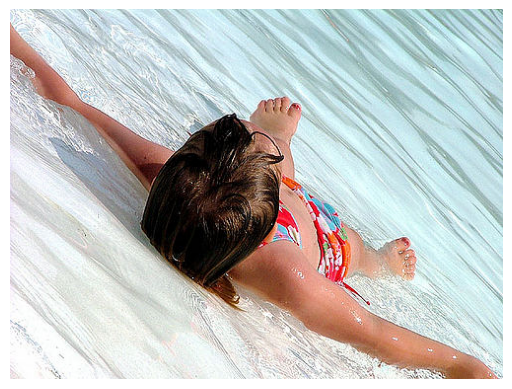

Caption 1: startseq girl is stretched out in shallow water endseq
Caption 2: startseq girl wearing red and multi colored bikini is laying on her back in shallow water endseq
Caption 3: startseq little girl in red swimsuit is laying on her back in shallow water endseq
Caption 4: startseq young girl is lying in the sand while ocean water is surrounding her endseq
Caption 5: startseq girl wearing bikini lying on her back in shallow pool of clear blue water endseq


In [13]:
import matplotlib.pyplot as plt
from PIL import Image

sample_image_id = "667626_18933d713e"
image_directory= os.path.join(base_directory, 'Images')
image_path = os.path.join(image_directory, f"{sample_image_id}.jpg")
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()

sample_captions = mapping.get(sample_image_id, [])
for i, caption in enumerate(sample_captions):
    print(f"Caption {i + 1}: {caption}")

## use tokenizer for all captions

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
        
len(all_captions)        

40455

In [15]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)
vocab_size

8426

### check max len of captions

In [17]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# And now is time for split dataset to train and test!!!

In [18]:
image_ids = list(mapping.keys())
split_count = int(len(image_ids) * 0.90)
train = image_ids[:split_count]
test = image_ids[split_count:]

In [19]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    num_samples = 0
    
    while True:
        for key in data_keys:
            num_samples += 1
            captions = mapping[key]
            
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if num_samples == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y  
                X1, X2, y = [], [], []  
                num_samples = 0


## Create final model :)

#### firts part for image features:

In [20]:
image_input = Input(shape=(4096,))
fe1 = Dropout(0.4)(image_input)
fe2 = Dense(256, activation='relu')(fe1)

#### second part for captions (text features)

In [21]:
text_input = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(text_input)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

#### Combine image and text features

In [64]:
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)

outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[image_input, text_input], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [23]:
def train_caption_model(model, train_data, mapping, features, tokenizer, max_length, vocab_size, batch_size, epochs):
    steps_per_epoch = len(train_data) // batch_size

    for epoch in range(epochs):
        generator = data_generator(train_data, mapping, features, tokenizer, max_length, vocab_size, batch_size)
        model.fit(generator, epochs=1, steps_per_epoch=steps_per_epoch, verbose=1)


In [24]:
epochs = 15
batch_size = 32

train_caption_model(model, train, mapping, features, tokenizer, max_length, vocab_size, batch_size, epochs)

227/227 [==============================] - 195s 858ms/step - loss: 2.3533


In [58]:
model.save(working_dir+'/my_model.keras')

## Generate Captions for the Image

In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [60]:
def predict_caption(model, image, tokenizer, max_length):
    
    in_text = 'startseq'
    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        y = model.predict([image, sequence])
        y = np.argmax(y)
        word = idx_to_word(y, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
      
    return in_text

In [56]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_directory+"\images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man in pink shirt climbs rock face endseq
startseq man is rock climbing high in the air endseq
startseq person in red shirt climbing up rock face covered in assist handles endseq
startseq rock climber in red shirt endseq
startseq rock climber practices on rock climbing wall endseq
1/1 [==============================] - 0s 17ms/step
--------------------Predicted--------------------
startseq man in red shirt is climbing up the edge of large rock endseq


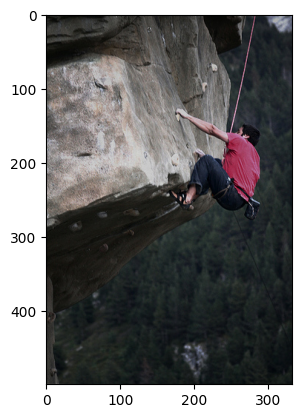

In [61]:
generate_caption("997722733_0cb5439472.jpg")